data_generation\generated_data\data_arrays_T100_n2_mu0.2.npz
####### Data loaded successfully. #######  
 Data Status: 
  num_processes:  2 
  num_timesteps:  10000 
 sum_of_first_poisson_process:  tensor(1834., dtype=torch.float64) 
 sum_of_first_thinned_process:  tensor(679., dtype=torch.float64)


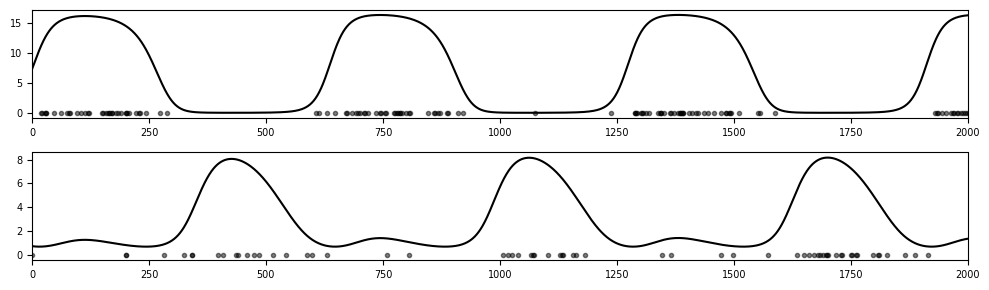

In [6]:
import os
import gc
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from dynamical_system import ODE
from helpers.helpers import Helper
from variational_inference.variational_inference import VariationalInference
from variational_inference.optimization_loop import optimization_loop
from data_generation.data_generator import DataGenerator
from time_grid_optimization.run_time_grid_opt import Global_Optimizer
from time_grid_optimization.time_grid_optimizer2 import Time_grid_optimizer2
from time_series.ts_Helper import TS_Helper
from helpers.plotter import plot_loss, plot_big_time_grid, plot_time_grid, plot_time_grid_kernel

######### load data #########
folder_name = 'data_generation\\generated_data'
#file_path = os.path.join(folder_name, 'data_arrays_T50_n2_mu0.5.npz')
name = 'data_arrays_T100_n2_mu0.2.npz'
#name = 'lorenz_T16000_n10_mu0.5.npz'
#name = 'data_lorenz_T5000_n8_mu0.8.npz'
file_path = os.path.join(folder_name, name)
print(file_path)
loaded_data = np.load(file_path)
full_gp_samples = loaded_data['gp_samples']
full_poisson_process = loaded_data['poisson_process']
full_thinned_process = loaded_data['thinned_process']

full_gp_samples = torch.tensor(full_gp_samples, dtype=torch.float64)
#!!!!!   cut down to train size    !!!!!
gp_samples = full_gp_samples[:, :10000]
full_poisson_process = torch.tensor(full_poisson_process, dtype=torch.float64)
full_thinned_process = torch.tensor(full_thinned_process, dtype=torch.float64)

######################################## preprocessing for lornez ########################################
######################################## preprocessing for lornez ########################################
######################################## preprocessing for lornez ########################################
'''
full_gp_samples = full_gp_samples[[0, 2, 4]]
full_thinned_process = full_thinned_process[[0, 2, 4]]
num_processes = 3

print(torch.sum(full_thinned_process))
one_length = 100
skip = 5
zero_length = 150
total_length = full_thinned_process.size(1)
i = 0
while i < total_length:
    if full_thinned_process[0][i] == 1:
        full_thinned_process[0][i:i+one_length:skip] = 1
        full_thinned_process[0][i+one_length:i+one_length+zero_length] = 0
        i += one_length + zero_length
    else:
        i += 1
full_thinned_process[0][4000:4200] = 0
zero_length = 150
i = 0
full_thinned_process[1][0:1000] = 0 
full_thinned_process[1][1500:1900] = 0 
full_thinned_process[1][2500:2700] = 0 
full_thinned_process[1][4000:4270] = 0 
one_length2  = one_length+50
while i < total_length:
    if full_thinned_process[1][i] == 1:
        full_thinned_process[1][i:i+one_length2:skip] = 1
        full_thinned_process[1][i+one_length:i+one_length2+zero_length] = 0
        i += one_length2 + zero_length
    else:
        i += 1
zero_length = 100
i = 0
while i < total_length:
    if full_thinned_process[2][i] == 1:
        full_thinned_process[2][i:i+one_length:skip] = 1
        full_thinned_process[2][i+one_length:i+one_length+zero_length] = 0
        i += one_length + zero_length
    else:
        i += 1

def remove_four_out_of_five_ones(tensor):
    result = tensor.clone()  # clone the tensor to avoid modifying the original
    for i in range(tensor.size(0)):  # iterate over each row
        ones_indices = (tensor[i] == 1).nonzero(as_tuple=True)[0]  # get indices of all 1's in the row
        
        # Verify we have enough 1's to perform the operation
        if len(ones_indices) < 4:
            continue  # skip this row if there are fewer than 5 occurrences of 1
        
        # Keep only every fifth occurrence by setting 4 out of every 5 indices to remove
        indices_to_keep = ones_indices[::4]  # indices to keep (every fifth one)
        indices_to_remove = ones_indices[~torch.isin(ones_indices, indices_to_keep)]  # all other indices
        
        result[i, indices_to_remove] = 0  # set these indices to 0
    return result
full_thinned_process = remove_four_out_of_five_ones(full_thinned_process)
print("newsum", torch.sum(full_thinned_process))
'''

######################################## preprocessing for lornez ########################################
######################################## preprocessing for lornez ########################################
######################################## preprocessing for lornez ########################################

DataGenerator.print_data_status(full_gp_samples, full_poisson_process, full_thinned_process)
DataGenerator.plot_generated_data(full_gp_samples, full_poisson_process, full_thinned_process, xlim=2000)
num_processes = full_thinned_process.shape[0]



c:\Users\gabri\OneDrive\Dokumente\Studium\Master Thesis\github\master_thesis\helpers\plotter.py:322: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau_list = torch.tensor(tau_list)


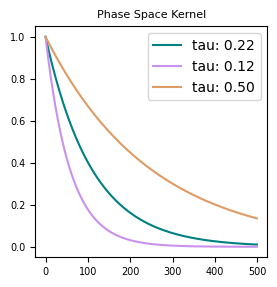

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Initial time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
############# plotting in 3d #############
time_grid (5000, 3)
data torch.Size([5000])
data torch.Size([5000])
data torch.Size([5000])


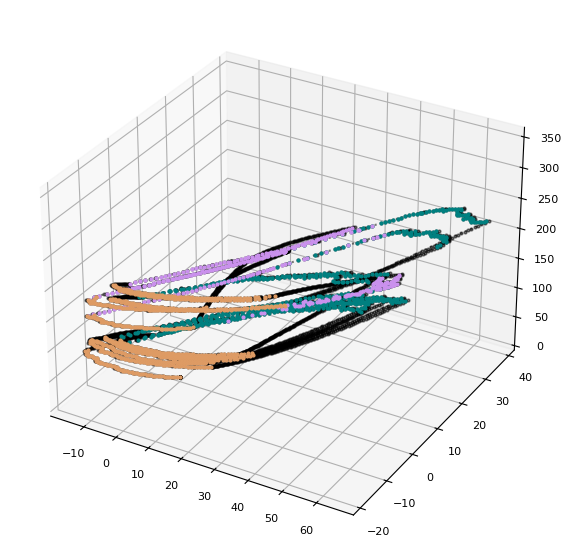



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 1   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 1860.47, time for iteration: 0.37s ##
   ## iteration: 2, L: 2068.14, time for iteration: 0.38s ##
   ## iteration: 3, L: 2222.74, time for iteration: 0.39s ##
   ## iteration: 4, L: 2298.94, time for iteration: 0.38s ##
   ## iteration: 5, L: 2341.29, time for iteration: 0.34s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.290917012236907
   ## L after hyper opt: 2356.39, time for hyper opt: 2.13s ##

   ## iteration: 6, L: 2383.04, time for iteration: 0.34s ##
   ## iteration: 7, L: 2398.99, time for iteration: 0.35s ##
   ## iteration: 8, L: 2408.77, time for iteration: 0.42s ##


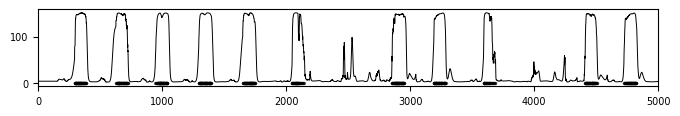



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 762.83, time for iteration: 0.35s ##
   ## iteration: 2, L: 883.85, time for iteration: 0.36s ##
   ## iteration: 3, L: 952.00, time for iteration: 0.35s ##
   ## iteration: 4, L: 984.10, time for iteration: 0.39s ##
   ## iteration: 5, L: 1002.08, time for iteration: 0.39s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.28635812358816
   ## L after hyper opt: 1010.81, time for hyper opt: 2.10s ##

   ## iteration: 6, L: 1024.13, time for iteration: 0.36s ##
   ## iteration: 7, L: 1032.62, time for iteration: 0.37s ##
   ## iteration: 8, L: 1038.60, time for iteration: 0.39s ##


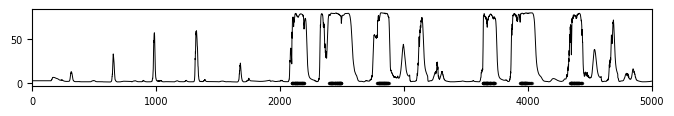



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 2774.48, time for iteration: 0.35s ##
   ## iteration: 2, L: 2998.12, time for iteration: 0.38s ##
   ## iteration: 3, L: 3154.78, time for iteration: 0.40s ##
   ## iteration: 4, L: 3228.25, time for iteration: 0.38s ##
   ## iteration: 5, L: 3268.29, time for iteration: 0.38s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.295295645772107
   ## L after hyper opt: 3285.78, time for hyper opt: 2.35s ##

   ## iteration: 6, L: 3312.30, time for iteration: 0.39s ##
   ## iteration: 7, L: 3330.85, time for iteration: 0.37s ##
   ## iteration: 8, L: 3344.15, time for iteration: 0.38s ##


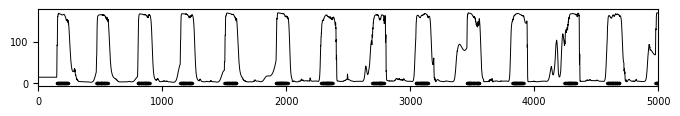

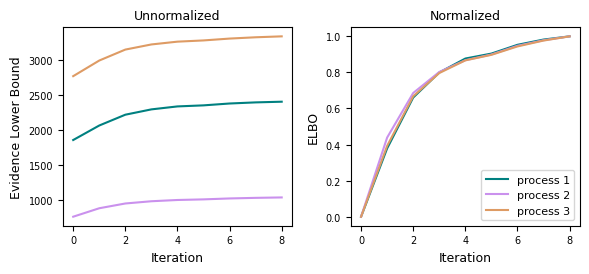


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 9459.34 to: 9456.62, time used: 25.52s @@



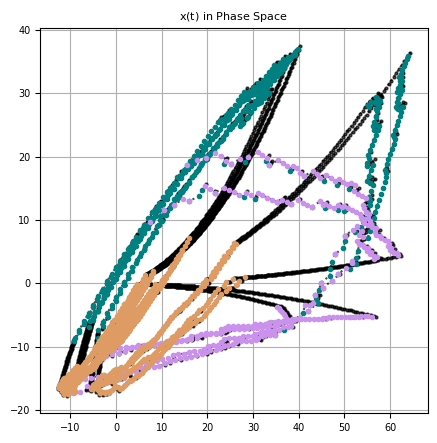



the new taus are: tensor([0.2160, 0.1089, 0.5047], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.9331,  1.1777,  0.0047],
        [ 1.3386, -0.1054,  4.3406],
        [-0.3522, -0.5477,  1.7293]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 2   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2417.59, time for iteration: 0.37s ##
   ## iteration: 2, L: 2422.14, time for iteration: 0.36s ##
   ## iteration: 3, L: 2425.08, time for iteration: 0.34s ##
   ## iteration: 4, L: 2427.05, time for iteration: 0.40s ##
   ## iteration: 5, L: 2428.41, time for iteration: 0.40s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.58779491907057
   ## L after hyper opt: 2449.68, time for hyper opt: 2.30s ##

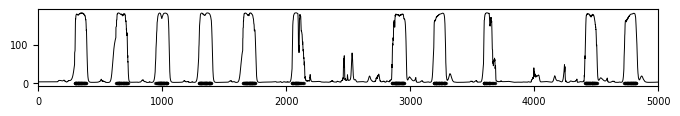



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1041.50, time for iteration: 0.36s ##
   ## iteration: 2, L: 1044.77, time for iteration: 0.41s ##
   ## iteration: 3, L: 1047.13, time for iteration: 0.42s ##
   ## iteration: 4, L: 1048.85, time for iteration: 0.39s ##
   ## iteration: 5, L: 1050.12, time for iteration: 0.38s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.578319922864775
   ## L after hyper opt: 1062.37, time for hyper opt: 2.19s ##

   ## iteration: 6, L: 1064.52, time for iteration: 0.39s ##
   ## iteration: 7, L: 1065.75, time for iteration: 0.34s ##
   ## iteration: 8, L: 1066.69, time for iteration: 0.37s ##


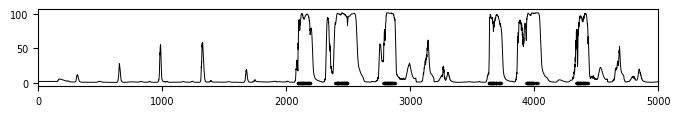



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3357.38, time for iteration: 0.36s ##
   ## iteration: 2, L: 3365.30, time for iteration: 0.36s ##
   ## iteration: 3, L: 3370.71, time for iteration: 0.40s ##
   ## iteration: 4, L: 3374.77, time for iteration: 0.37s ##
   ## iteration: 5, L: 3377.86, time for iteration: 0.40s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.590463276245597
   ## L after hyper opt: 3401.21, time for hyper opt: 2.48s ##

   ## iteration: 6, L: 3404.75, time for iteration: 0.36s ##
   ## iteration: 7, L: 3407.25, time for iteration: 0.41s ##
   ## iteration: 8, L: 3409.04, time for iteration: 0.38s ##


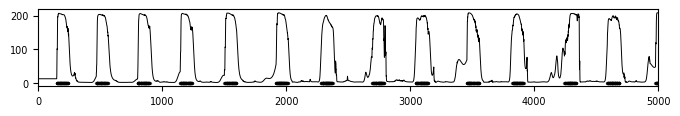

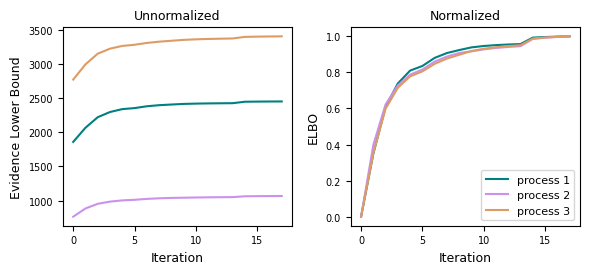


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 10219.84 to: 10216.00, time used: 25.78s @@



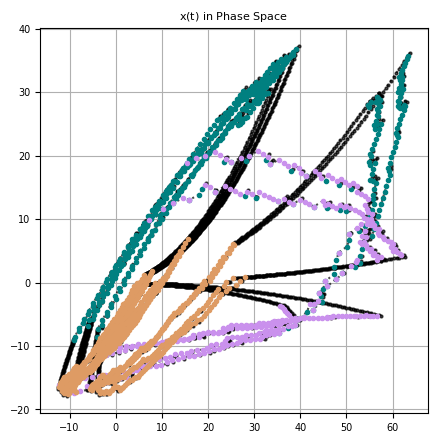



the new taus are: tensor([0.2134, 0.1064, 0.5081], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.9211,  1.1872,  0.0111],
        [ 1.3580, -0.1086,  4.3349],
        [-0.3479, -0.5562,  1.7355]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 3   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2453.51, time for iteration: 0.36s ##
   ## iteration: 2, L: 2454.46, time for iteration: 0.38s ##
   ## iteration: 3, L: 2455.02, time for iteration: 0.36s ##
   ## iteration: 4, L: 2455.39, time for iteration: 0.37s ##
   ## iteration: 5, L: 2455.65, time for iteration: 0.39s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.884678427975402
   ## L after hyper opt: 2477.03, time for hyper opt: 2.28s #

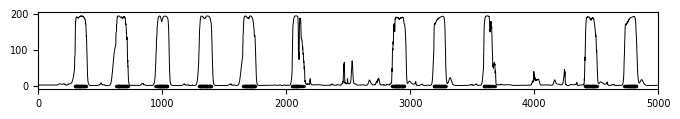



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1066.27, time for iteration: 0.36s ##
   ## iteration: 2, L: 1066.99, time for iteration: 0.36s ##
   ## iteration: 3, L: 1067.46, time for iteration: 0.34s ##
   ## iteration: 4, L: 1067.81, time for iteration: 0.36s ##
   ## iteration: 5, L: 1068.07, time for iteration: 0.38s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.87432701232051
   ## L after hyper opt: 1081.29, time for hyper opt: 2.27s ##

   ## iteration: 6, L: 1082.25, time for iteration: 0.35s ##
   ## iteration: 7, L: 1082.72, time for iteration: 0.38s ##
   ## iteration: 8, L: 1083.07, time for iteration: 0.37s ##


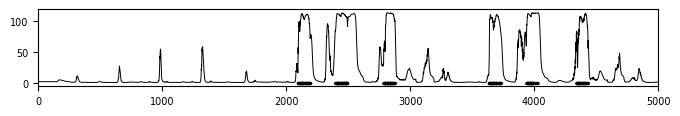



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3410.35, time for iteration: 0.36s ##
   ## iteration: 2, L: 3411.73, time for iteration: 0.39s ##
   ## iteration: 3, L: 3412.53, time for iteration: 0.37s ##
   ## iteration: 4, L: 3413.06, time for iteration: 0.42s ##
   ## iteration: 5, L: 3413.43, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 10.886039845340902
   ## L after hyper opt: 3437.73, time for hyper opt: 2.31s ##

   ## iteration: 6, L: 3438.88, time for iteration: 0.38s ##
   ## iteration: 7, L: 3439.46, time for iteration: 0.40s ##
   ## iteration: 8, L: 3439.86, time for iteration: 0.38s ##


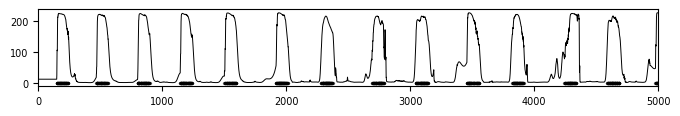

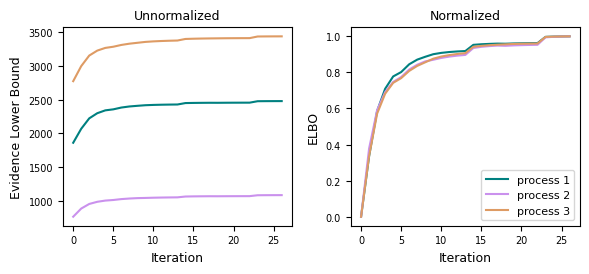


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 10626.83 to: 10596.99, time used: 26.22s @@



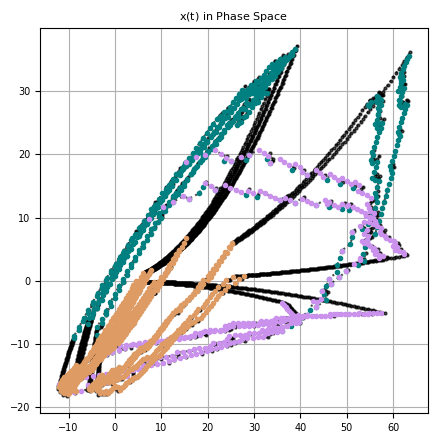



the new taus are: tensor([0.2109, 0.1051, 0.5063], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.9178,  1.1917,  0.0059],
        [ 1.3788, -0.1075,  4.3072],
        [-0.3428, -0.5711,  1.7285]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 4   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2479.60, time for iteration: 0.35s ##
   ## iteration: 2, L: 2480.27, time for iteration: 0.39s ##
   ## iteration: 3, L: 2480.56, time for iteration: 0.39s ##
   ## iteration: 4, L: 2480.73, time for iteration: 0.42s ##
   ## iteration: 5, L: 2480.83, time for iteration: 0.38s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.181503584884428
   ## L after hyper opt: 2501.17, time for hyper opt: 2.28s #

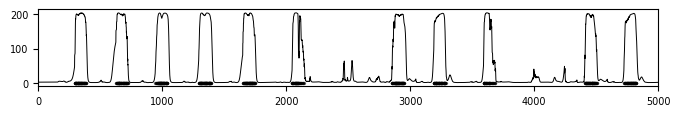



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1083.86, time for iteration: 0.35s ##
   ## iteration: 2, L: 1084.39, time for iteration: 0.33s ##
   ## iteration: 3, L: 1084.64, time for iteration: 0.38s ##
   ## iteration: 4, L: 1084.81, time for iteration: 0.37s ##
   ## iteration: 5, L: 1084.92, time for iteration: 0.36s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.170251950678429
   ## L after hyper opt: 1097.95, time for hyper opt: 2.15s ##

   ## iteration: 6, L: 1098.73, time for iteration: 0.37s ##
   ## iteration: 7, L: 1099.02, time for iteration: 0.38s ##
   ## iteration: 8, L: 1099.24, time for iteration: 0.39s ##


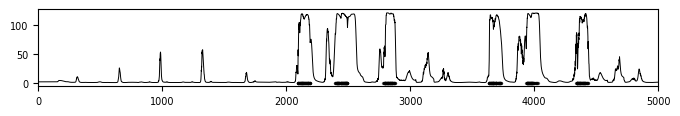



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3441.00, time for iteration: 0.38s ##
   ## iteration: 2, L: 3442.33, time for iteration: 0.38s ##
   ## iteration: 3, L: 3442.97, time for iteration: 0.38s ##
   ## iteration: 4, L: 3443.35, time for iteration: 0.41s ##
   ## iteration: 5, L: 3443.61, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.181268511488684
   ## L after hyper opt: 3466.72, time for hyper opt: 2.26s ##

   ## iteration: 6, L: 3467.69, time for iteration: 0.40s ##
   ## iteration: 7, L: 3468.11, time for iteration: 0.39s ##
   ## iteration: 8, L: 3468.41, time for iteration: 0.37s ##


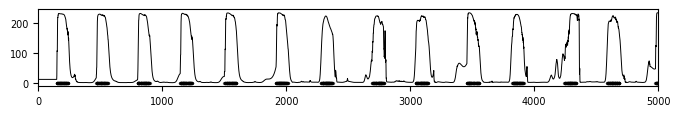

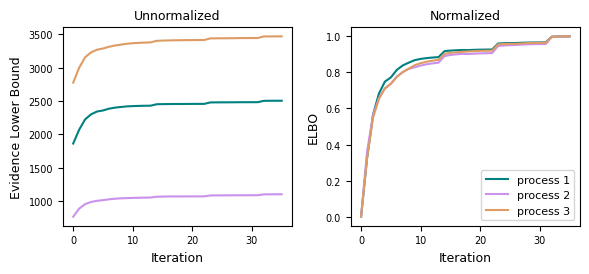


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 10938.76 to: 10929.44, time used: 25.33s @@



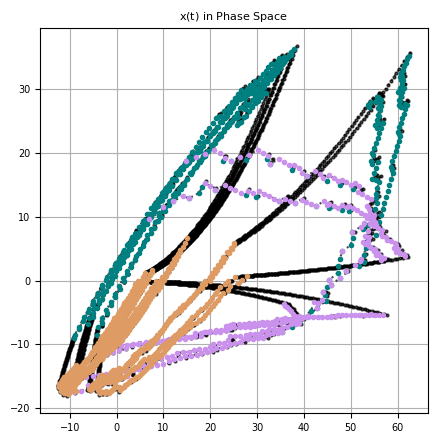



the new taus are: tensor([0.2129, 0.1043, 0.5052], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 8.9613e-01,  1.1861e+00,  3.9102e-04],
        [ 1.3626e+00, -1.1692e-01,  4.2886e+00],
        [-3.4819e-01, -5.6958e-01,  1.7145e+00]], device='cuda:0',
       dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 5   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2501.58, time for iteration: 0.34s ##
   ## iteration: 2, L: 2502.29, time for iteration: 0.38s ##
   ## iteration: 3, L: 2502.58, time for iteration: 0.37s ##
   ## iteration: 4, L: 2502.75, time for iteration: 0.36s ##
   ## iteration: 5, L: 2502.86, time for iteration: 0.40s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.478240151890503
   ## L after hype

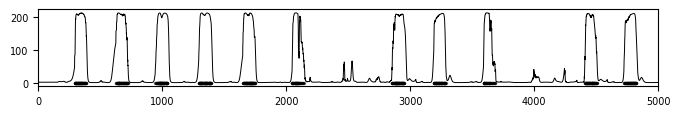



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1099.28, time for iteration: 0.34s ##
   ## iteration: 2, L: 1099.57, time for iteration: 0.37s ##
   ## iteration: 3, L: 1099.69, time for iteration: 0.37s ##
   ## iteration: 4, L: 1099.78, time for iteration: 0.38s ##
   ## iteration: 5, L: 1099.84, time for iteration: 0.42s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.465972746200627
   ## L after hyper opt: 1112.44, time for hyper opt: 2.24s ##

   ## iteration: 6, L: 1113.16, time for iteration: 0.35s ##
   ## iteration: 7, L: 1113.37, time for iteration: 0.35s ##
   ## iteration: 8, L: 1113.53, time for iteration: 0.35s ##


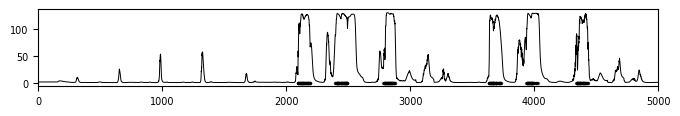



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3469.23, time for iteration: 0.39s ##
   ## iteration: 2, L: 3469.82, time for iteration: 0.37s ##
   ## iteration: 3, L: 3470.09, time for iteration: 0.37s ##
   ## iteration: 4, L: 3470.25, time for iteration: 0.37s ##
   ## iteration: 5, L: 3470.35, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.47630568890616
   ## L after hyper opt: 3492.58, time for hyper opt: 2.38s ##

   ## iteration: 6, L: 3493.39, time for iteration: 0.38s ##
   ## iteration: 7, L: 3493.67, time for iteration: 0.41s ##
   ## iteration: 8, L: 3493.85, time for iteration: 0.39s ##


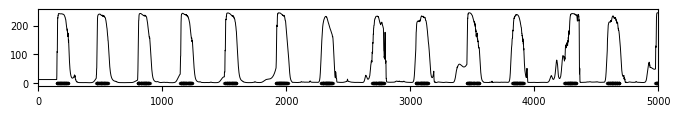

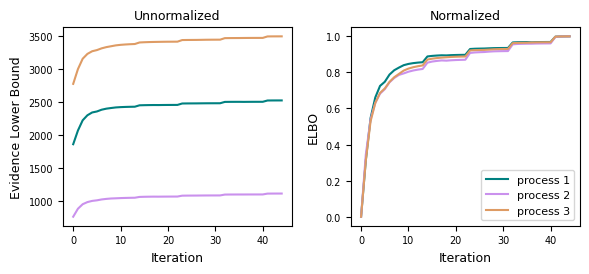


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 11208.43 to: 11202.68, time used: 26.28s @@



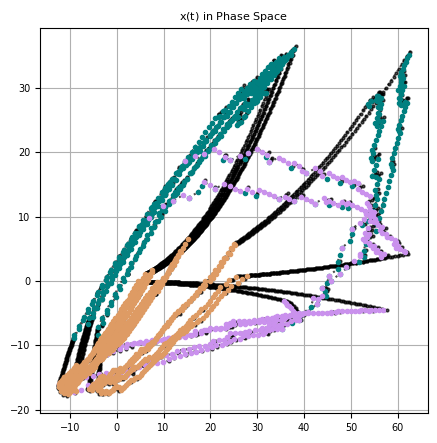



the new taus are: tensor([0.2142, 0.1036, 0.5049], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 8.9131e-01,  1.1795e+00,  4.1765e-03],
        [ 1.3584e+00, -9.1229e-02,  4.2948e+00],
        [-3.4813e-01, -5.6358e-01,  1.7034e+00]], device='cuda:0',
       dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 6   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2524.15, time for iteration: 0.39s ##
   ## iteration: 2, L: 2524.37, time for iteration: 0.37s ##
   ## iteration: 3, L: 2524.48, time for iteration: 0.38s ##
   ## iteration: 4, L: 2524.56, time for iteration: 0.45s ##
   ## iteration: 5, L: 2524.62, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.774762323004373
   ## L after hype

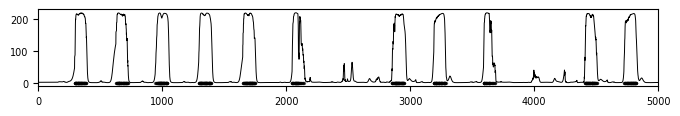



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1112.36, time for iteration: 0.34s ##
   ## iteration: 2, L: 1112.57, time for iteration: 0.35s ##
   ## iteration: 3, L: 1112.67, time for iteration: 0.35s ##
   ## iteration: 4, L: 1112.74, time for iteration: 0.33s ##
   ## iteration: 5, L: 1112.79, time for iteration: 0.35s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.761382865869582
   ## L after hyper opt: 1124.71, time for hyper opt: 2.13s ##

   ## iteration: 6, L: 1125.39, time for iteration: 0.40s ##
   ## iteration: 7, L: 1125.57, time for iteration: 0.44s ##
   ## iteration: 8, L: 1125.71, time for iteration: 0.37s ##


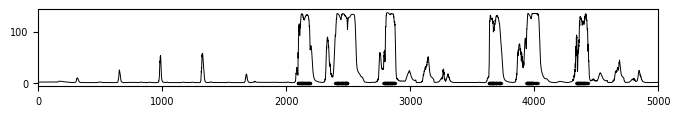



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3495.31, time for iteration: 0.43s ##
   ## iteration: 2, L: 3495.50, time for iteration: 0.38s ##
   ## iteration: 3, L: 3495.59, time for iteration: 0.42s ##
   ## iteration: 4, L: 3495.66, time for iteration: 0.39s ##
   ## iteration: 5, L: 3495.71, time for iteration: 0.40s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 11.770893670292722
   ## L after hyper opt: 3516.55, time for hyper opt: 2.35s ##

   ## iteration: 6, L: 3517.29, time for iteration: 0.39s ##
   ## iteration: 7, L: 3517.50, time for iteration: 0.36s ##
   ## iteration: 8, L: 3517.63, time for iteration: 0.39s ##


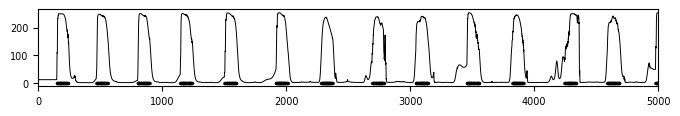

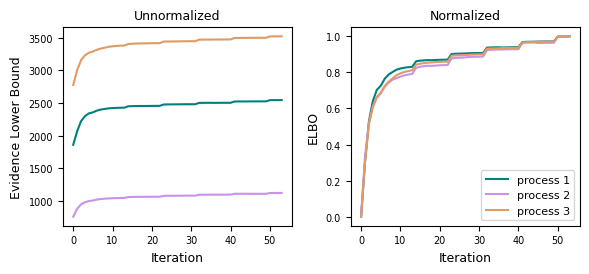


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 11458.46 to: 11451.31, time used: 27.26s @@



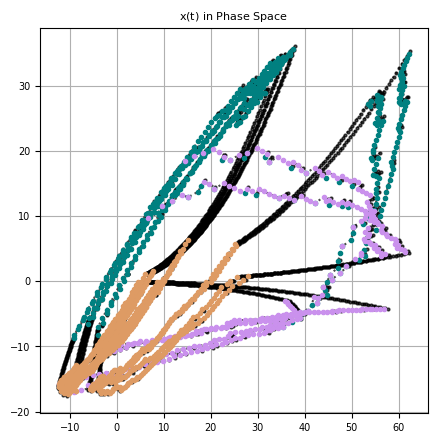



the new taus are: tensor([0.2156, 0.1031, 0.5044], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.8827,  1.1706,  0.0068],
        [ 1.3563, -0.0833,  4.2962],
        [-0.3481, -0.5564,  1.6929]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 7   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2544.08, time for iteration: 0.44s ##
   ## iteration: 2, L: 2544.29, time for iteration: 0.42s ##
   ## iteration: 3, L: 2544.40, time for iteration: 0.46s ##
   ## iteration: 4, L: 2544.48, time for iteration: 0.39s ##
   ## iteration: 5, L: 2544.53, time for iteration: 0.39s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.071092860766642
   ## L after hyper opt: 2561.66, time for hyper opt: 2.36s #

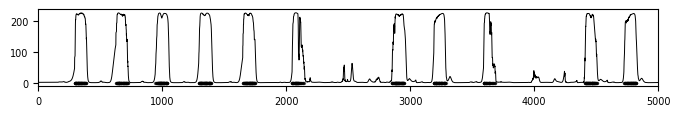



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1124.95, time for iteration: 0.35s ##
   ## iteration: 2, L: 1125.11, time for iteration: 0.37s ##
   ## iteration: 3, L: 1125.19, time for iteration: 0.34s ##
   ## iteration: 4, L: 1125.25, time for iteration: 0.36s ##
   ## iteration: 5, L: 1125.29, time for iteration: 0.38s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.056371445147988
   ## L after hyper opt: 1136.52, time for hyper opt: 2.24s ##

   ## iteration: 6, L: 1137.18, time for iteration: 0.36s ##
   ## iteration: 7, L: 1137.35, time for iteration: 0.41s ##
   ## iteration: 8, L: 1137.47, time for iteration: 0.39s ##


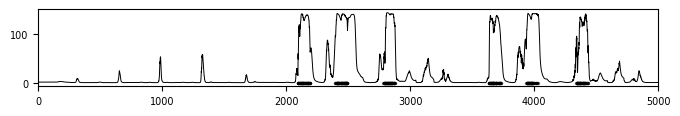



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3518.17, time for iteration: 0.38s ##
   ## iteration: 2, L: 3518.36, time for iteration: 0.40s ##
   ## iteration: 3, L: 3518.45, time for iteration: 0.38s ##
   ## iteration: 4, L: 3518.51, time for iteration: 0.37s ##
   ## iteration: 5, L: 3518.55, time for iteration: 0.35s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.064963802415944
   ## L after hyper opt: 3538.05, time for hyper opt: 2.32s ##

   ## iteration: 6, L: 3538.77, time for iteration: 0.38s ##
   ## iteration: 7, L: 3538.95, time for iteration: 0.39s ##
   ## iteration: 8, L: 3539.07, time for iteration: 0.37s ##


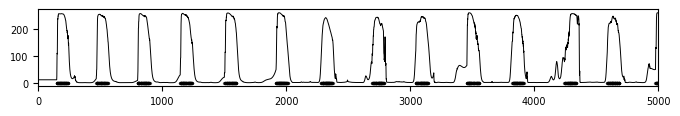

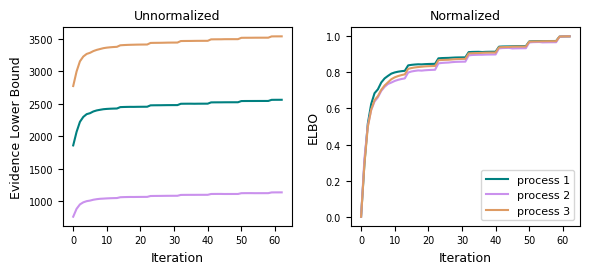


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 11700.15 to: 11693.95, time used: 26.00s @@



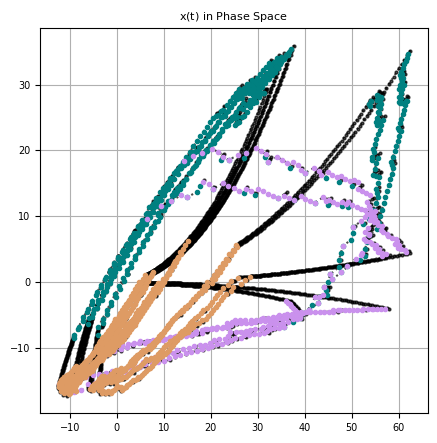



the new taus are: tensor([0.2176, 0.1028, 0.5039], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.8734,  1.1644,  0.0126],
        [ 1.3586, -0.0787,  4.2963],
        [-0.3488, -0.5478,  1.6840]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 8   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2562.75, time for iteration: 0.39s ##
   ## iteration: 2, L: 2562.92, time for iteration: 0.39s ##
   ## iteration: 3, L: 2563.02, time for iteration: 0.40s ##
   ## iteration: 4, L: 2563.09, time for iteration: 0.41s ##
   ## iteration: 5, L: 2563.14, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.367182599809446
   ## L after hyper opt: 2579.08, time for hyper opt: 2.35s #

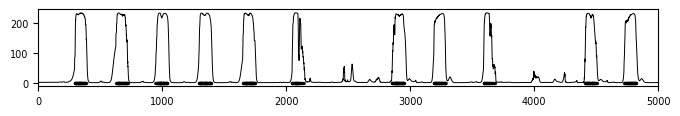



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1136.62, time for iteration: 0.40s ##
   ## iteration: 2, L: 1136.77, time for iteration: 0.38s ##
   ## iteration: 3, L: 1136.85, time for iteration: 0.37s ##
   ## iteration: 4, L: 1136.91, time for iteration: 0.36s ##
   ## iteration: 5, L: 1136.95, time for iteration: 0.39s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.350915898659517
   ## L after hyper opt: 1147.47, time for hyper opt: 2.36s ##

   ## iteration: 6, L: 1148.13, time for iteration: 0.35s ##
   ## iteration: 7, L: 1148.28, time for iteration: 0.35s ##
   ## iteration: 8, L: 1148.39, time for iteration: 0.40s ##


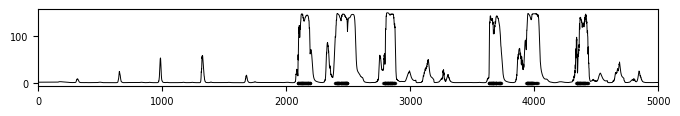



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3539.07, time for iteration: 0.37s ##
   ## iteration: 2, L: 3539.29, time for iteration: 0.39s ##
   ## iteration: 3, L: 3539.39, time for iteration: 0.39s ##
   ## iteration: 4, L: 3539.45, time for iteration: 0.38s ##
   ## iteration: 5, L: 3539.49, time for iteration: 0.41s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.358463143666903
   ## L after hyper opt: 3557.66, time for hyper opt: 2.40s ##

   ## iteration: 6, L: 3558.36, time for iteration: 0.40s ##
   ## iteration: 7, L: 3558.52, time for iteration: 0.39s ##
   ## iteration: 8, L: 3558.62, time for iteration: 0.40s ##


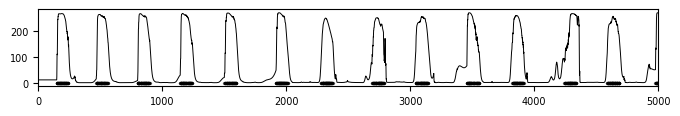

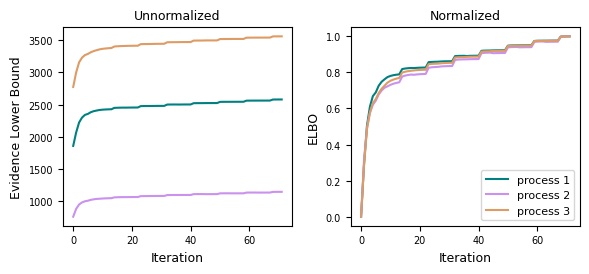


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 11937.36 to: 11931.07, time used: 26.30s @@



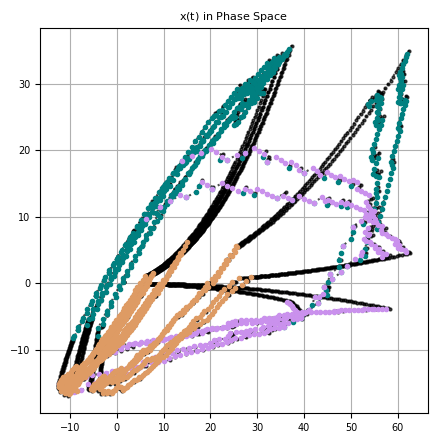



the new taus are: tensor([0.2200, 0.1026, 0.5033], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.8636,  1.1587,  0.0197],
        [ 1.3605, -0.0742,  4.2958],
        [-0.3503, -0.5385,  1.6762]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 9   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2579.99, time for iteration: 0.40s ##
   ## iteration: 2, L: 2580.16, time for iteration: 0.38s ##
   ## iteration: 3, L: 2580.27, time for iteration: 0.42s ##
   ## iteration: 4, L: 2580.34, time for iteration: 0.44s ##
   ## iteration: 5, L: 2580.40, time for iteration: 0.38s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.662975453206945
   ## L after hyper opt: 2595.15, time for hyper opt: 2.38s #

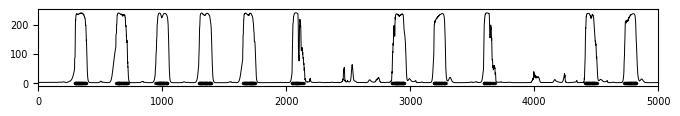



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1147.44, time for iteration: 0.39s ##
   ## iteration: 2, L: 1147.60, time for iteration: 0.38s ##
   ## iteration: 3, L: 1147.68, time for iteration: 0.35s ##
   ## iteration: 4, L: 1147.74, time for iteration: 0.38s ##
   ## iteration: 5, L: 1147.78, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.644987214973971
   ## L after hyper opt: 1157.60, time for hyper opt: 2.47s ##

   ## iteration: 6, L: 1158.25, time for iteration: 0.38s ##
   ## iteration: 7, L: 1158.39, time for iteration: 0.40s ##
   ## iteration: 8, L: 1158.49, time for iteration: 0.36s ##


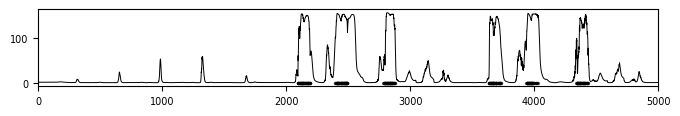



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3558.29, time for iteration: 0.36s ##
   ## iteration: 2, L: 3558.56, time for iteration: 0.39s ##
   ## iteration: 3, L: 3558.66, time for iteration: 0.41s ##
   ## iteration: 4, L: 3558.72, time for iteration: 0.35s ##
   ## iteration: 5, L: 3558.76, time for iteration: 0.37s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.6513719123199
   ## L after hyper opt: 3575.62, time for hyper opt: 2.49s ##

   ## iteration: 6, L: 3576.31, time for iteration: 0.41s ##
   ## iteration: 7, L: 3576.45, time for iteration: 0.38s ##
   ## iteration: 8, L: 3576.54, time for iteration: 0.38s ##


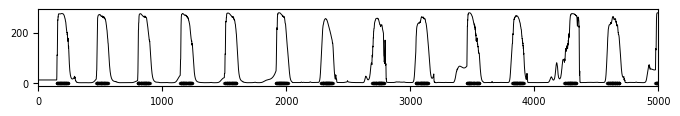

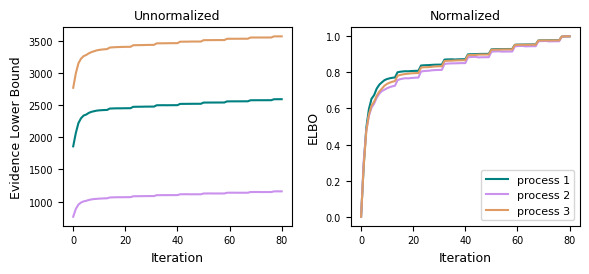


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@


   @@ Global_ELBO from: 12170.53 to: 12153.37, time used: 26.94s @@



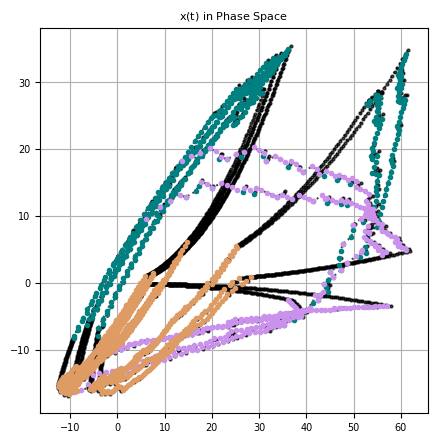



the new taus are: tensor([0.2196, 0.1025, 0.5022], device='cuda:0', dtype=torch.float64)
the new couplings are: tensor([[ 0.8499,  1.1526,  0.0189],
        [ 1.3509, -0.0599,  4.2858],
        [-0.3500, -0.5348,  1.6675]], device='cuda:0', dtype=torch.float64)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 10   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (8 Iterations) ############
   ## iteration: 1, L: 2595.78, time for iteration: 0.39s ##
   ## iteration: 2, L: 2596.03, time for iteration: 0.39s ##
   ## iteration: 3, L: 2596.16, time for iteration: 0.39s ##
   ## iteration: 4, L: 2596.25, time for iteration: 0.42s ##
   ## iteration: 5, L: 2596.31, time for iteration: 0.39s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.958483949985027
   ## L after hyper opt: 2610.02, time for hyper opt: 2.31s 

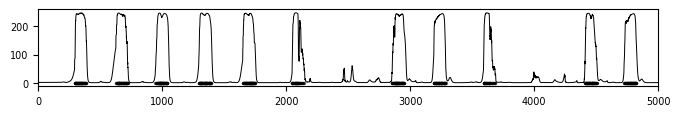



############ Optimization Process: 2 (8 Iterations) ############
   ## iteration: 1, L: 1158.10, time for iteration: 0.35s ##
   ## iteration: 2, L: 1158.31, time for iteration: 0.39s ##
   ## iteration: 3, L: 1158.39, time for iteration: 0.39s ##
   ## iteration: 4, L: 1158.45, time for iteration: 0.39s ##
   ## iteration: 5, L: 1158.49, time for iteration: 0.35s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.938482039323493
   ## L after hyper opt: 1167.66, time for hyper opt: 2.19s ##

   ## iteration: 6, L: 1168.30, time for iteration: 0.38s ##
   ## iteration: 7, L: 1168.43, time for iteration: 0.38s ##
   ## iteration: 8, L: 1168.52, time for iteration: 0.37s ##


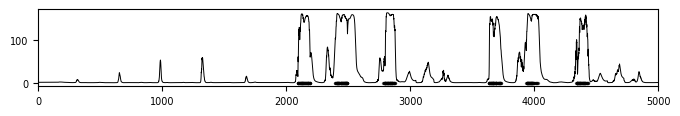



############ Optimization Process: 3 (8 Iterations) ############
   ## iteration: 1, L: 3576.52, time for iteration: 0.44s ##
   ## iteration: 2, L: 3576.72, time for iteration: 0.37s ##
   ## iteration: 3, L: 3576.82, time for iteration: 0.37s ##
   ## iteration: 4, L: 3576.88, time for iteration: 0.37s ##
   ## iteration: 5, L: 3576.92, time for iteration: 0.39s ##

   ######  hyperparameter optimization (3 Epochs)  ######
   new kernel lengthscale 12.94365178167034
   ## L after hyper opt: 3592.49, time for hyper opt: 2.48s ##

   ## iteration: 6, L: 3593.19, time for iteration: 0.39s ##
   ## iteration: 7, L: 3593.32, time for iteration: 0.37s ##
   ## iteration: 8, L: 3593.41, time for iteration: 0.36s ##


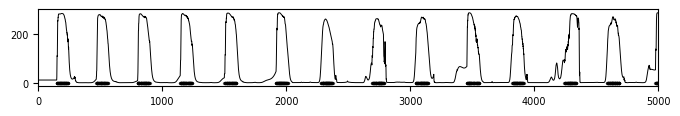

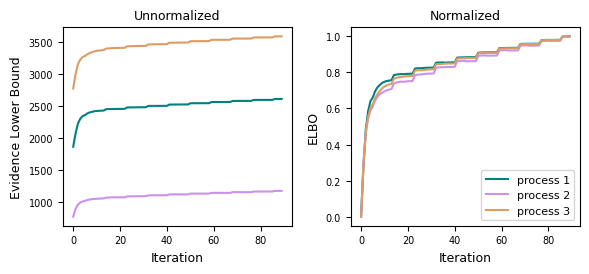



overall time used:  497.8836350440979
time for optimization:  91.08975250134245
time for hyperparameter optimization:  69.16646369965747
time for phase space optimization:  235.6350432995241


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
############# plotting in 3d #############
time_grid (5000, 3)
data torch.Size([5000])
data torch.Size([5000])
data torch.Size([5000])


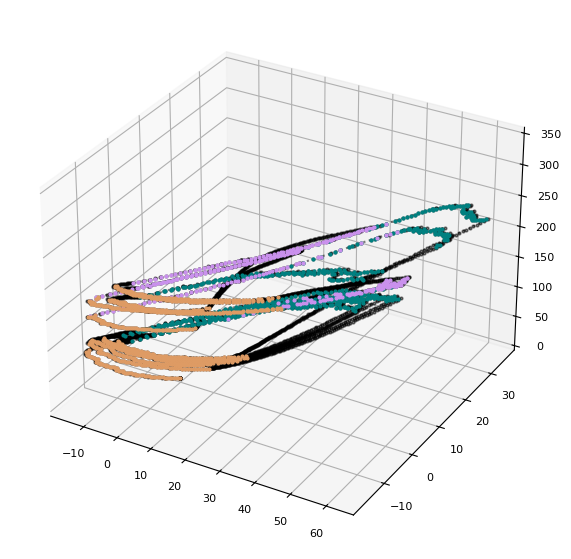

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting EBLO @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

   ELBO of process 0: 2610.96
   ELBO of process 1: 1168.52
   ELBO of process 2: 3593.41

   ### Global ELBO: 7372.90 ###

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@    Algorithm terminated   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


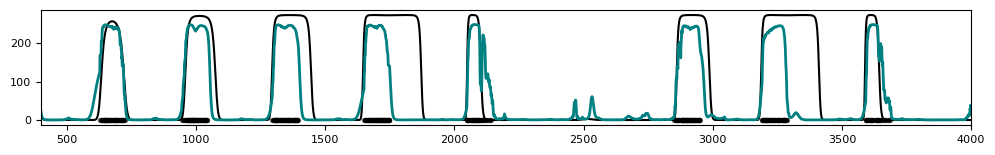

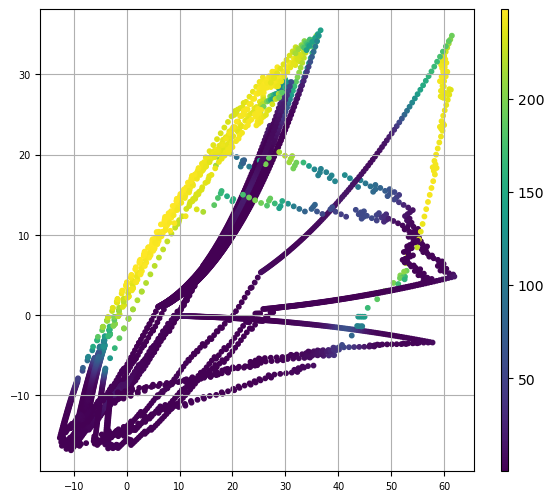

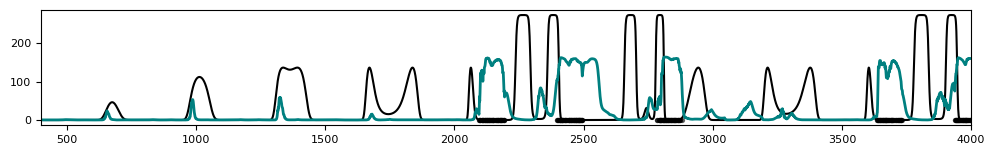

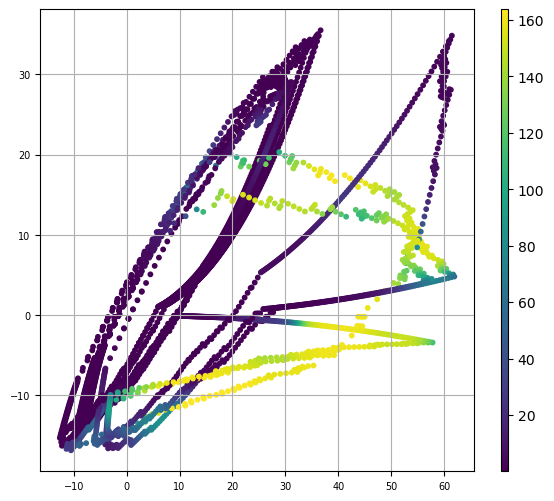

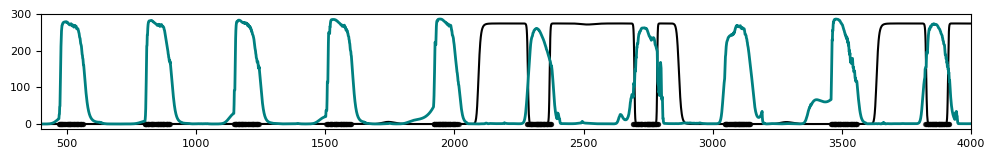

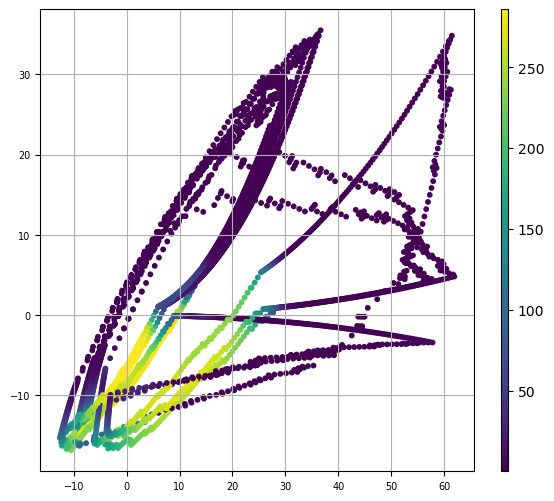

In [30]:
list_vi_objects = []
loss_tracker_all_processes = []
global_opt_time_tracker = 0
global_hyperparam_time_tracker = 0
global_phase_space_time_tracker = 0

###### define parameters ######
'''    !! end_time x time_discretization will be the train split !!    '''
end_time                         = 10         # end time of the data
time_discretization              = 500         # diskretizaiton of the time
time_grid_kernel_effect_length   = 1           # length of the kernel in time grid space (for tau<1 the log(tau) is added to the length)
dim_phase_space                  = 3 #!!!      # attention, on initialization of tau and couplings
tau_list                         = [0.22, 0.116, 0.5]
gp_kernel                        = 'RBF'       # 'RBF' or 'Matern'


if type(full_thinned_process) == torch.Tensor:
    list_full_processes = []
    list_processes = []
    for i in range(num_processes):
        list_full_processes.append(full_thinned_process[i])
        list_processes.append(full_thinned_process[i, :end_time*time_discretization])
elif type(full_thinned_process) == np.ndarray:
    list_full_processes = []
    list_processes = []
    for i in range(num_processes):
        list_full_processes.append(torch.tensor(full_thinned_process[i], dtype=torch.float64))
        list_processes.append(torch.tensor(full_thinned_process[i, :end_time*time_discretization]), dtype=torch.float64)
elif type(full_thinned_process) == list:
    list_processes = []
    for i in range(num_processes):
        list_processes = full_thinned_process[i][:end_time*time_discretization]
else:
    raise ValueError('thinned_process must be a list, numpy array or torch tensor')

seed_value = 14
torch.manual_seed(seed_value)
tau_list =       torch.tensor(tau_list, dtype=torch.float64)
couplings =     torch.zeros(num_processes, dim_phase_space, dtype=torch.float64)
couplings[0] =  torch.tensor([ 9.3438e-01,  1.1646e+00,  4.0722e-03], dtype=torch.float64)  
couplings[1] =  torch.tensor( [ 1.3283e+00, -9.2844e-02,  4.3522e+00], dtype=torch.float64)

couplings[2] =  torch.tensor(  [-3.5595e-01, -5.4905e-01,  1.7348e+00], dtype=torch.float64) 

#couplings[3] =  torch.tensor([-1,-1,-1], dtype=torch.float64)
#couplings[4] =  torch.tensor([0,0,0], dtype=torch.float64)
#couplings[5] =  torch.tensor([-1,-1,0], dtype=torch.float64)
#couplings[6] =  torch.tensor([ 0,0,0], dtype=torch.float64)
#couplings[7] =  torch.tensor([ 0,0,0], dtype=torch.float64)
#couplings[8] =  torch.tensor([-1, -.7, -.2], dtype=torch.float64)
#couplings[9] =  torch.tensor([-1, -1, 1], dtype=torch.float64)
#couplings[10] =  torch.tensor([.5, -1, 1], dtype=torch.float64)
#couplings[11] =  torch.tensor([-2, -2, -.3], dtype=torch.float64)

#couplings =      (torch.rand(num_processes, dim_phase_space) * 2) - 1

time_grid_parameters = {
    'tau_list':           tau_list,
    'couplings':          couplings,}
optimality_parameters = {
    "alpha_post":         None,
    "beta_post":          None,
    "mu_post":            None,
    "cov_post":           None }
hyperparameters = {
    'kernel_outputscale':     torch.tensor(6. , dtype=torch.float64),
    'kernel_lengthscale':     torch.tensor(10. , dtype=torch.float64),
    'alpha_0':                torch.tensor(4 , dtype=torch.float64),
    'beta_0':                 torch.tensor(1 , dtype=torch.float64),
    'GP_prior_mean':          torch.tensor(.0 , dtype=torch.float64),
    'inducing_points_s':      None,
    'tau_list':               tau_list,
    'couplings':              couplings}

###### define parameters ######
algorithm_iterations          = 10           # number of iterations alternating between time-grid opt and per process opt
iterations_per_process        = 8           # num iteratons of optimality update per process per algorithm iteration

epochs_per_hyp_tuning         = 3
epochs_time_grid              = 30
time_hyp_opt                  = [5,12]      # at which iteration to optimize the hyperparameters per prcoess

learning_rate_optimization    = 0.05
learning_rate_tau             = 0.05
learning_rate_couplings       = 0.05

termination_threshold_opt     = .1          # threshold for the loss to terminate ooptimality update per process
termination_threshold_tg      = 1.
gradient_clip_norm            = 3000.
num_inducing_points_per_dim   = 6          # gets raised by the power of dim of phase space

ts_helper = TS_Helper(full_thinned_process, full_gp_samples, dim_phase_space, num_processes, end_time, time_grid_kernel_effect_length, time_discretization)
#global_opt = Time_grid_optimizer2(list_vi_objects, ts_helper, time_grid_parameters, learning_rate_tau, learning_rate_couplings, epochs_time_grid, gradient_clip_norm, termination_threshold_tg)
plot_time_grid_kernel(ts_helper, tau_list, size=3)

print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Initial time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
time_grid = ts_helper.get_time_grid(couplings, tau_list)
plot_big_time_grid(ts_helper, time_grid, size=7, start=0, end=10000, tau_list=tau_list, couplings=couplings)

start_time= time.time()
for i in range(algorithm_iterations):
    print("\n")
    print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print(f'@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: {i+1}   @@@@@@@@@@@@@@@@@@')
    print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print("\n")
    list_vi_objects, loss_tracker_all_processes, global_full_stack_params, hyperparam_time_tracker, opt_time_tracker = optimization_loop(i,
                        list_full_processes, optimality_parameters, hyperparameters, time_grid_parameters, 
                        ts_helper, num_inducing_points_per_dim, learning_rate_optimization, time_hyp_opt, 
                        termination_threshold_opt, iterations_per_process, epochs_per_hyp_tuning,
                        list_vi_objects, loss_tracker_all_processes, gp_kernel #, global_full_stack_params
                        )
    plot_loss(loss_tracker_all_processes, size=3)
    global_hyperparam_time_tracker += hyperparam_time_tracker
    global_opt_time_tracker += opt_time_tracker
    #global_opt.set_time_grid_params(ts_helper, time_grid_parameters, global_full_stack_params)
    #time_grid_params = global_opt.optimize_time_grid(epochs_time_grid, learning_rate_time_grid)
    if i <= algorithm_iterations-2:
        #device = torch.device("cpu")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        global_opt = Time_grid_optimizer2(device, list_vi_objects, ts_helper, time_grid_parameters, learning_rate_tau, learning_rate_couplings, epochs_time_grid, gradient_clip_norm, termination_threshold_tg)
        global_opt.to(device)
        #global_opt.set_vi_objects(list_vi_objects)
        time_grid_parameters, time_tracker = global_opt.optimize_time_grid(list_vi_objects)
        global_opt.to_cpu()
        global_phase_space_time_tracker += time_tracker
        Helper.set_time_grid_params(list_vi_objects, time_grid_parameters)
        del global_opt
        gc.collect()
end_time = time.time()
print("\n")
print("overall time used: ", end_time-start_time)
print("time for optimization: ", global_opt_time_tracker)
print("time for hyperparameter optimization: ", global_hyperparam_time_tracker)
print("time for phase space optimization: ", global_phase_space_time_tracker)
print("\n")

print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
time_grid = ts_helper.get_time_grid(time_grid_parameters['couplings'], time_grid_parameters['tau_list'])
plot_big_time_grid(ts_helper, time_grid, size=7, start=0, end=5000, tau_list=time_grid_parameters['tau_list'], couplings=time_grid_parameters['couplings'])

print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting EBLO @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n")
globad_ELBO = 0
for i, tensor in enumerate(loss_tracker_all_processes):
    last_element = tensor[-1]
    print(f"   ELBO of process {i}: {last_element:.2f}")
    globad_ELBO += last_element
print(f"\n   ### Global ELBO: {globad_ELBO:.2f} ###\n")

print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print(f'@@@@@@@@@@@@@@@@@@@    Algorithm terminated   @@@@@@@@@@@@@@@@@@')
print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

for i, vi in enumerate(list_vi_objects):
    vi.loss_tracker_all = loss_tracker_all_processes
    vi.cal_predictive_rate()
    vi.plot_results(gp_samples[i],  c_map='viridis', start=400, xlim=4000)
    #vi.plot_surface(points_per_axis=50, start=400, xlim=3000)


In [24]:
#save as pickle
import pickle
folder_name = 'stored_runs'
name = f'{name}.pickle'
file_path = os.path.join(folder_name, name)
with open(file_path, 'wb') as file:
    pickle.dump(list_vi_objects, file)

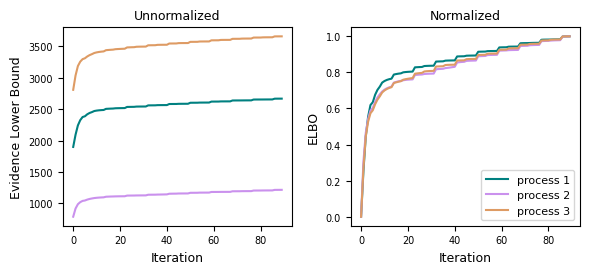

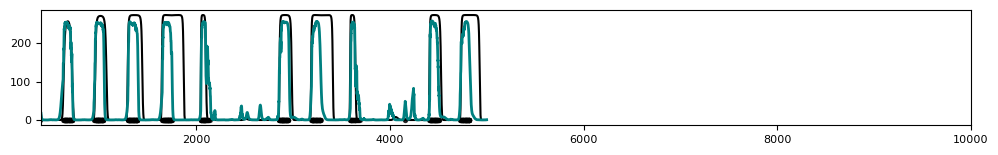

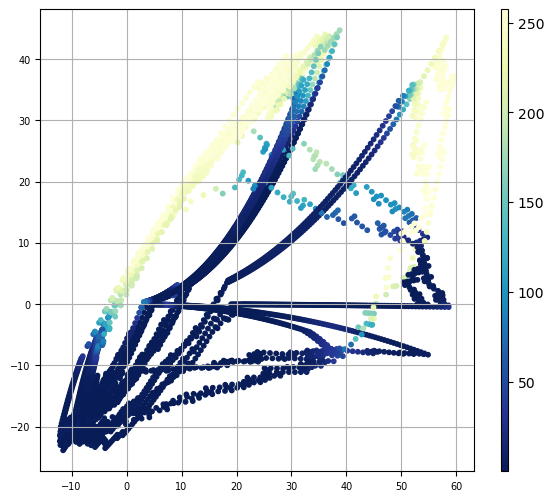

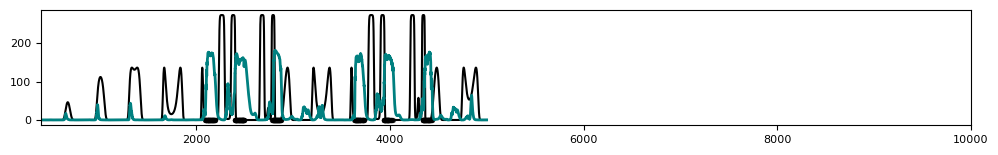

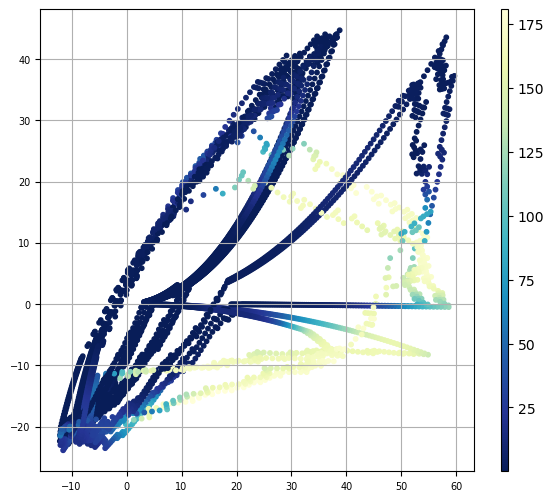

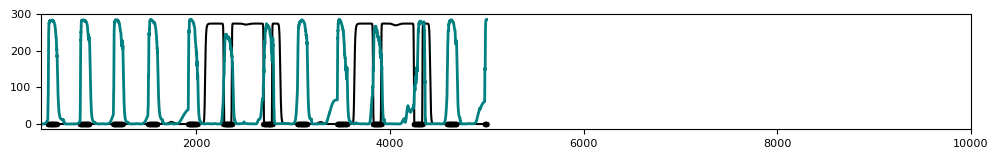

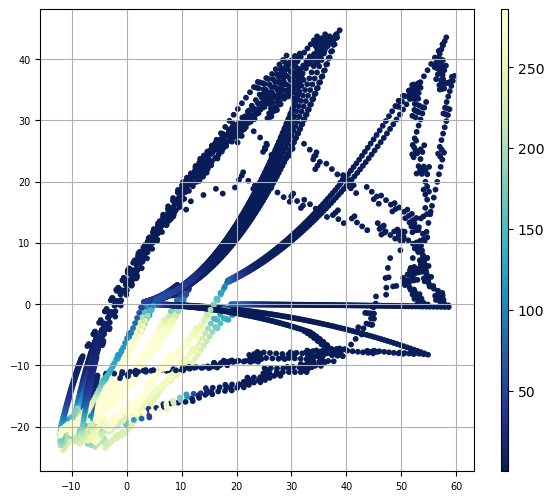

In [25]:
plot_loss(loss_tracker_all_processes, size=3)

for i, vi in enumerate(list_vi_objects):
    vi.cal_predictive_rate()
    vi.plot_results(gp_samples[i],  c_map='YlGnBu_r', start=400, xlim=10000)
    #vi.plot_surface(points_per_axis=50, start=400, xlim=3000)